In [1]:
from sklearn.manifold import TSNE
from umap import UMAP

In [2]:
%run load-clean-select.ipynb

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Morphology was measured for 1029.0 cells.

The numbers of cells and nuclei correspond to each other.

The are no duplicated column names: True
The are no duplicated column names: True
Cytoplasm measurements were taken for 1029 cells.

The are no duplicated column names: True

Full dataset has shape: (1029, 338)
Initial shape is: (1029, 338)
Features with zero variance:
 Index(['centerZ_cell', 'children_cytoplasm_count_cell',
       'loc_centermassintensityZ_wga', 'loc_centerZ_cell',
       'loc_maxintensityZ_wga', 'centerZ_nucl', 'eulernumber_nucl',
       'children_cells_count', 'children_cytoplasm_count_nucl',
       'loc_centermassintensityZ_dapi', 'loc_centerZ_nucl',
       'loc_maxintensityZ_dapi', 'centerZ_cyto'],
      dtype='object')

After cleaning the dataset has 1029 rows and 298 columns.

177 columns in total:
 7 columns containing metadata, meta_cols,
 170 all features, feature_cols:
 0 biomarkers, biom_cols,
 170 morphology, morph_cols
116 geometric measurements, geom_col

# Which dataset?

In [3]:
# The full dataset
# df = measurements
# Dataset without clusters at 64kPa
df = measurements_red
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa
# df = measurements_5
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa with balanced classes
# df = measurements_b

In [ ]:
q1 = measurements.log_ratio.quantile(0.25)
q3 = measurements.log_ratio.quantile(0.75)
measurements['level'] = pd.cut(measurements.log_ratio,
                               bins=(measurements.log_ratio.min(), q1, q3, measurements.log_ratio.max()), 
                               labels=["low", "med", "high"], include_lowest=True)

In [ ]:
measurements['log_ker'] = np.log(measurements.meanintensity_ker)
measurements['log_vim'] = np.log(measurements.meanintensity_vim)

measurements['region'] = "low"
measurements.loc[(measurements.log_ker < measurements.log_ker.median()) &
                 (measurements.log_vim > measurements.log_vim.median()), 'region'] = "high vim"
measurements.loc[(measurements.log_ker > measurements.log_ker.median()) &
                 (measurements.log_vim < measurements.log_vim.median()), 'region'] = "high ker"
measurements.loc[(measurements.log_ker > measurements.log_ker.median()) &
                 (measurements.log_vim > measurements.log_vim.median()), 'region'] = "high"

In [9]:
def plot_embedding(df, X_emb, title='', hue='stiffness', centroids=False):

    cols = [('x_' + str(i)) for i in range(1, X_emb.shape[1] + 1)]
    df = pd.concat([df[hue],
                    pd.DataFrame(data = X_emb, columns = cols)], 
                   axis=1)
    
    plt.figure()        
    if hue == 'level':
        palette = dict(zip(df.level.unique(), sns.color_palette("Set1", 3)))
        ax = sns.scatterplot( x="x_1", y="x_2", data=df,
                             hue=hue, palette=palette,
                             legend='full')
    elif hue == 'region':
        palette = dict(zip(df.region.unique(), sns.color_palette("Set1", 4)))
        ax = sns.scatterplot( x="x_1", y="x_2", data=df,
                             hue=hue, palette=palette,
                             legend='full')
    elif hue == 'stiffness':
        nstiff = df.stiffness.unique().size
        palette = dict(zip(df.stiffness.unique(), sns.color_palette("Set2", nstiff)))
        ax = sns.scatterplot( x="x_1", y="x_2", data=df,
                             hue=hue, palette=palette,
                             legend='full')
    else:
        ax = sns.scatterplot( x="x_1", y="x_2", data=df, hue=hue, palette='PRGn_r')
        
    ax.set_title(title + " projection of the cell dataset")

In [5]:
def tune_umap(X, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    # Calculate UMAP embedding
    umap = UMAP(n_neighbors=n_neighbors,
                min_dist=min_dist,
                n_components=n_components,
                metric=metric, 
                random_state=1)
    X_emb = umap.fit_transform(X);
    
    # Plot UMAP projection 
    nstiff = df.stiffness.unique().size
    my_palette = dict(zip(df.stiffness.unique(), sns.color_palette("Set3", nstiff)))

    cols = [('x_' + str(i)) for i in range(1, X_emb.shape[1] + 1)]
    df = pd.concat([df.loc[:, 'stiffness'],
                    pd.DataFrame(data = X_emb, columns = cols)], 
                   axis=1)
    
    plt.figure()
    ax = sns.scatterplot( x="x_1", y="x_2", data=df,
                         hue='stiffness', palette=sns.color_palette("Set3", 7),
                         legend='full')
    ax.set_title("UMAP projection of the cell dataset. " + title)

### All features

In [6]:
X = df[feature_cols]

tsne = TSNE()

X_emb = tsne.fit_transform(X)
plot_embedding(df, X_emb, "t-SNE")

AttributeError: 'str' object has no attribute 'shape'

In [ ]:
X = df[biom_cols]

umap = UMAP()

X_emb = umap.fit_transform(X)
plot_embedding(X_emb, "UMAP")

In [ ]:
X = df[biom_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE()

X_emb = tsne.fit_transform(X_scaled)
plot_embedding(X_emb, "t-SNE")

In [ ]:
X = df[biom_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

umap = UMAP()

X_emb = umap.fit_transform(X_scaled)
plot_embedding(X_emb, "UMAP")

In [ ]:
for n in (5, 10, 15, 20, 50, 100, 200):
    tune_umap(X_scaled, n_neighbors=n, title='n_neighbors = {}'.format(n))

In [ ]:
for d in (0.0, 0.1, 0.15, 0.2, 0.25, 0.5, 0.99):
    tune_umap(X_scaled, min_dist=d, title='min_dist = {}'.format(d))

In [ ]:
# Minkowski style metrics
for m in ('euclidean', 'manhattan', 'chebyshev', 'minkowski'):
    tune_umap(X_scaled, metric=m, title='metric = {}'.format(m))

In [ ]:
# Miscellaneous spacial metrics
for m in ('canberra', 'braycurtis'):
    tune_umap(X_scaled, metric=m, title='metric = {}'.format(m))

In [ ]:
# Normalized spatial metrics
# weighted minkowski requires a weight vector `w` to be given.

for m in ('mahalanobis', 'cosine', 'correlation'):
    tune_umap(X_scaled, metric=m, title='metric = {}'.format(m))

### Morphological features

In [7]:
cols = feature_cols
X = df[geom_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(perplexity=50)

X_emb = tsne.fit_transform(X_scaled)

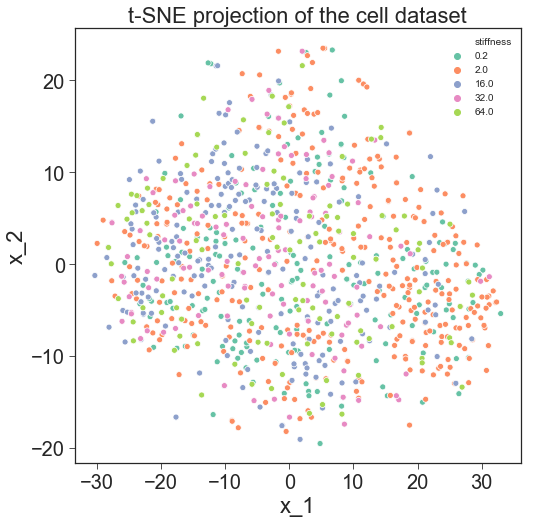

In [10]:
plot_embedding(df, X_emb, "t-SNE", 'stiffness')

In [ ]:
cols = geom_cols
X = df[geom_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

umap = UMAP(n_neighbors=100, min_dist=0.1, n_components=2)

X_emb = umap.fit_transform(X_scaled)

In [ ]:
col = 'stiffness'
df_umap = pd.concat([measurements[col], 
                     pd.DataFrame(X_emb, columns=['x_1', 'x_2'])],
                    axis=1)

centroids = df_umap.groupby('stiffness')[['x_1', 'x_2']].mean().reset_index()

palette = dict(zip(measurements.stiffness.unique(), sns.color_palette("Set3", 7)))
ax = sns.scatterplot(x="x_1", y="x_2", data=df_umap, hue='stiffness', palette=palette);
sns.scatterplot(x="x_1", y="x_2", data=centroids, 
                hue='stiffness', palette=palette, 
                s=200, marker='X', edgecolor='black', 
                legend=None);

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(df_umap[['prod']], df_umap[col])
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
print(lin_reg.intercept_, lin_reg.coef_)
y_pred = lin_reg.predict(X_test)
print("Testing RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Null RMSE:", np.sqrt(mean_squared_error(y_test, y_test.apply(lambda x: np.mean(y_train)))))

In [ ]:
for n in (5, 10, 15, 20, 50, 100, 200):
    tune_umap(X_scaled, n_neighbors=n, title='n_neighbors = {}'.format(n))

In [ ]:
for d in (0.0, 0.1, 0.15, 0.2, 0.25, 0.5, 0.99):
    tune_umap(X_scaled, min_dist=d, title='min_dist = {}'.format(d))

In [ ]:
# Minkowski style metrics
for m in ('euclidean', 'manhattan', 'chebyshev', 'minkowski'):
    tune_umap(X_scaled, metric=m, title='metric = {}'.format(m))

#### UMAP + PCA

In [ ]:
X = df[biom_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)

# Apply PCA to the scaled feature matrix
X_reduced = pca.fit_transform(X_scaled)

# umap = UMAP()

umap = UMAP(n_neighbors=50, min_dist=0.3, n_components=2)

X_emb = umap.fit_transform(X_reduced)

plot_embedding(X_emb, "UMAP", centroids=True)

In [ ]:
col = 'stiffness'
df_umap = pd.concat([measurements[col], 
                     pd.DataFrame(X_emb, columns=['x_1', 'x_2'])],
                    axis=1)
sns.set(rc={'figure.figsize':(8, 8)})

sns.lmplot(x=col, y='x_1', data=df_umap);

In [ ]:
plot_embedding(X_emb, "t-SNE", 'stiffness')

In [ ]:
df_tsne = pd.concat([measurements[col], 
                     pd.DataFrame(X_emb, columns=['x_1', 'x_2'])],
                    axis=1)
sns.lmplot(x='x_1', y='x_2', data=df_tsne, 
           col='stiffness', hue='stiffness', palette=sns.color_palette("Set3", 7), 
           sharex=True, sharey=True, col_wrap=3);

In [ ]:
col = 'stiffness'
df_umap = pd.concat([measurements[col], 
                     pd.DataFrame(X_emb, columns=['x_1', 'x_2'])],
                    axis=1)

palette = sns.color_palette("Set3", 7)
sns.boxplot(x=df_umap.stiffness, y=df_umap.x_1, palette=palette);
plt.xlabel("Stiffness, kPa")
plt.ylabel("x_1")
plt.title("First coordinate");

In [ ]:
sns.boxplot(x=df_umap.stiffness, y=df_umap.x_2, palette=palette);
plt.xlabel("Stiffness, kPa")
plt.ylabel("x_2")
plt.title("Second coordinate");